In [2]:
import keras 
import math
import os, glob
import numpy as np
import pandas as pd
import soundfile as sf
import tensorflow as tf
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras import backend as K
from keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

In [2]:
DATA_DIR_GUITAR = "./data/audio/Guitar_Only/"
CLASSES = ['a', 'am', 'bm', 'c', 'd', 'dm', 'e', 'em', 'f', 'g']
CLASSES_MAP = {'a':0, 'am':1, 'bm':2, 'c':3, 'd':4, 'dm':5, 'e':6, 'em':7, 'f':8, 'g':9}
METADATA_DIR_RAW = "./data/metadata/raw/"
METADATA_DIR_PROCESSED = "./data/metadata/processed/"
DATA_DIR_AUGMENTED = "./data/augmented/"
METADATA_DIR_AUGMENTED_RAW = "./data/augmented/raw"
METADATA_DIR_AUGMENTED_PROCESSED = "./data/augmented/processed"
MODEL_DIR = "./model/"
MODEL_JSON = "./model/model.json"
MODEL_H5 = "./model/model.h5"

In [3]:
len(glob.glob(DATA_DIR_GUITAR + "**/*.wav"))

2000

In [4]:
def df_info(f):
    def inner(df, *args, **kwargs):
        result = f(df, *args, **kwargs)
        print(f"After applying {f.__name__}, shape of df = {result.shape }")
        print(f"Columns of df are {df.columns}\n")
        return result
    return inner

# Construct Dataframe with all required values
@df_info
def construct_dataframe(df):
    df['file_path'] = file_path
    df['file_path'] = df['file_path'].map(lambda x: x[x.rindex('Only\\')+len('Only\\'):])
    df['file_name'] = df['file_path'].map(lambda x: x[x.rindex('\\')+1:])
    df['class_name'] = df['file_path'].map(lambda x: x[:x.index('\\')])
    df['class_ID'] = df['class_name'].map(lambda x: CLASSES_MAP[x])
    return df.copy()

# Extract spectrogram from audio
@df_info
def get_spectrogram(df):
    df['audio_series'] = df['file_path'].map(lambda x: librosa.load(DATA_DIR_GUITAR + x, duration=2))
    df['y'] = df['audio_series'].map(lambda x: x[0])
    df['sr'] = df['audio_series'].map(lambda x: x[1])
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'], sr=row['sr']), axis=1)
    df.drop(columns='audio_series', inplace=True)
    return df

@df_info
def get_count(df):
    return df['class_name'].value_counts()

@df_info
def add_shape(df):
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    return df

In [5]:
file_path = glob.glob("./data/audio/Guitar_Only/" + "**/*.wav")
data_df_raw = (pd.DataFrame().pipe(construct_dataframe)
                            .pipe(get_spectrogram)
                             .pipe(add_shape)
            )

After applying construct_dataframe, shape of df = (2000, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID'], dtype='object')

After applying get_spectrogram, shape of df = (2000, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')

After applying add_shape, shape of df = (2000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



In [6]:
get_count(data_df_raw)

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



class_name
a     200
am    200
bm    200
c     200
d     200
dm    200
e     200
em    200
f     200
g     200
Name: count, dtype: int64

In [8]:
data_df_raw.to_csv(os.path.join(METADATA_DIR_RAW, 'data.csv'), index=False)
data_df_raw.to_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [7]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [9]:
data_df_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,shape
0,a\a1.wav,a1.wav,a,0,"[-0.00044090126, -0.0005725771, -0.0003972128,...",22050,"[[1.4596096e-05, 0.00024260356, 0.00096791255,...","(128, 52)"
1,a\a10.wav,a10.wav,a,0,"[0.025644582, 0.03873189, 0.034305602, 0.03391...",22050,"[[0.013701358, 0.003172148, 0.001500244, 0.001...","(128, 66)"
2,a\a100.wav,a100.wav,a,0,"[-0.00018296344, -0.0002981358, -0.0002974281,...",22050,"[[0.0003008564, 0.00028734427, 0.00024939654, ...","(128, 81)"
3,a\a101.wav,a101.wav,a,0,"[0.0004918799, 0.00016076537, -0.00018280663, ...",22050,"[[0.0050224112, 0.005019856, 0.004343026, 0.00...","(128, 71)"
4,a\a102.wav,a102.wav,a,0,"[-0.0071322983, -0.010516543, -0.008813906, -0...",22050,"[[0.004694343, 0.0048317523, 0.0040243855, 0.0...","(128, 77)"


In [10]:
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process(df):
    df = (df.pipe(clean_shape)
                .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name']]
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df['spectrogram'].values, df['class_ID'].values
    X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

def get_class(class_ID):
    return list(CLASSES_MAP.keys())[list(CLASSES_MAP.values()).index(class_ID)]

In [11]:
data_df_processed = process(data_df_raw)

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (633, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')

After applying over_sample, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')

After applying process, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_20200\2670538892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='shape', inplace=True)


In [12]:
get_count(data_df_processed)

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name'], dtype='object')



class_name
a     115
am    115
bm    115
c     115
d     115
dm    115
e     115
em    115
f     115
g     115
Name: count, dtype: int64

In [13]:
data_df_processed.to_csv(os.path.join(METADATA_DIR_PROCESSED, 'data.csv'), index=False)
data_df_processed.to_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [14]:
data_df_processed.head()

,spectrogram,class_ID,class_name
0,"[[0.0047523906, 0.004513992, 0.0045696595, 0.0...",0,a
1,"[[0.007935312, 0.009195907, 0.0041631414, 0.00...",0,a
2,"[[0.009259402, 0.0056097205, 0.004018, 0.00440...",0,a
3,"[[0.003362876, 0.00532303, 0.003621814, 0.0045...",0,a
4,"[[0.00042518272, 0.00048722717, 0.0003344478, ...",0,a


In [15]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[0],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 52)

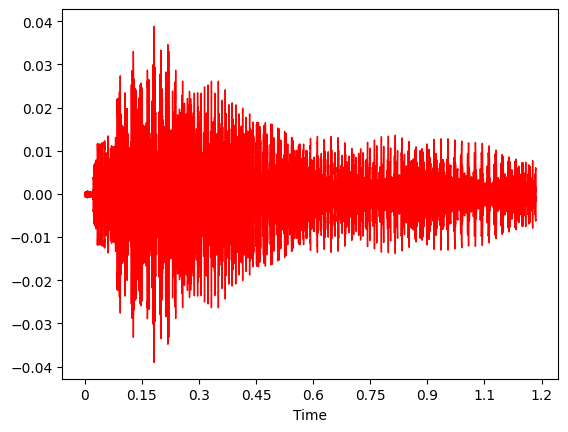

In [24]:
librosa.display.waveshow(y, sr=sr, color= "red")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

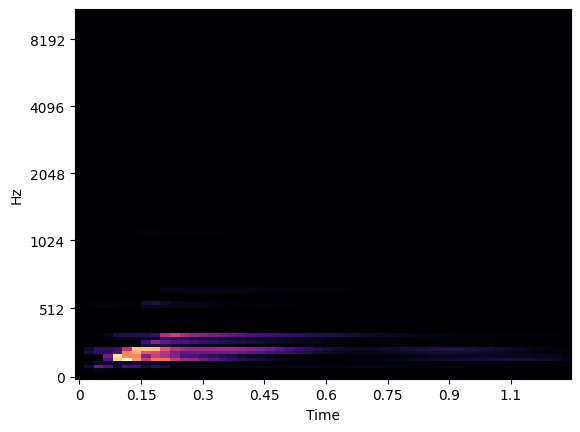

In [16]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [25]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [26]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [27]:
def get_augmentation_count(df):
    return df['augmentation'].value_counts()
@df_info
def augment_data(df, kind='time', rate=1.07):
    if kind == 'time':
        df['y'] = df['y'].map(lambda y:librosa.effects.time_stretch(y, rate=rate))
        new_path = 'speed_' + str(int(rate*100))
    elif kind == 'pitch':
        df['y'] = df.apply(lambda row:librosa.effects.pitch_shift(row['y'], sr=row['sr'], n_steps=rate), axis=1)
        new_path = 'pitch_' + str(int(rate*100))
    df['file_path'] = df.apply(lambda row: row['class_name']+'/'+new_path+"/"+row['file_name'], axis=1)
    for class_name in CLASSES:
        directory = os.path.join(DATA_DIR_AUGMENTED,class_name,new_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
    path_exists_mask =  df['file_path'].map(lambda x: not os.path.exists(os.path.join(DATA_DIR_AUGMENTED, x)))
    df[path_exists_mask].apply(lambda row: sf.write(os.path.join(DATA_DIR_AUGMENTED, row['file_path']),row['y'], row['sr']), axis=1)   
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'],sr=row['sr']),axis=1)
    df['augmentation'] = new_path
    return df

In [28]:
data_df_time_inc = augment_data(data_df_raw.copy(), kind='time', rate=1.07)
data_df_time_dec = augment_data(data_df_raw.copy(), kind='time', rate=0.81)

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [29]:
data_df_shift_20 = augment_data(data_df_raw.copy(), kind='pitch', rate=2.5)
data_df_shift_25 = augment_data(data_df_raw.copy(), kind='pitch', rate=2)

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [31]:
data_df_raw['augmentation'] = 'None'
data_df_augmented_raw = pd.concat([data_df_raw, data_df_time_inc, data_df_time_dec, data_df_shift_20, data_df_shift_25], axis=0)

In [32]:
data_df_augmented_raw = data_df_augmented_raw.pipe(add_shape)

After applying add_shape, shape of df = (10000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [33]:
print(get_augmentation_count(data_df_augmented_raw))

augmentation
None         2000
speed_107    2000
speed_81     2000
pitch_250    2000
pitch_200    2000
Name: count, dtype: int64


In [35]:
print(get_count(data_df_augmented_raw))

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

class_name
a     1000
am    1000
bm    1000
c     1000
d     1000
dm    1000
e     1000
em    1000
f     1000
g     1000
Name: count, dtype: int64


In [36]:
data_df_augmented_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,shape,augmentation
0,a\a1.wav,a1.wav,a,0,"[-0.00044090126, -0.0005725771, -0.0003972128,...",22050,"[[1.4596096e-05, 0.00024260356, 0.00096791255,...","(128, 52)",None
1,a\a10.wav,a10.wav,a,0,"[0.025644582, 0.03873189, 0.034305602, 0.03391...",22050,"[[0.013701358, 0.003172148, 0.001500244, 0.001...","(128, 66)",None
2,a\a100.wav,a100.wav,a,0,"[-0.00018296344, -0.0002981358, -0.0002974281,...",22050,"[[0.0003008564, 0.00028734427, 0.00024939654, ...","(128, 81)",None
3,a\a101.wav,a101.wav,a,0,"[0.0004918799, 0.00016076537, -0.00018280663, ...",22050,"[[0.0050224112, 0.005019856, 0.004343026, 0.00...","(128, 71)",None
4,a\a102.wav,a102.wav,a,0,"[-0.0071322983, -0.010516543, -0.008813906, -0...",22050,"[[0.004694343, 0.0048317523, 0.0040243855, 0.0...","(128, 77)",None


In [37]:
data_df_augmented_raw.to_csv(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.csv'), index=False)
data_df_augmented_raw.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))

In [38]:
data_df_augmented_raw = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))

In [39]:
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process_augmented(df):
    df = (df.pipe(clean_shape)
            .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name', 'augmentation']]
    
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df[['spectrogram', 'augmentation']].values, df['class_ID'].values
#     X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['augmentation'] = pd.Series([np.array(x[1]) for x in X])
    df['augmentation'] = df['augmentation'].map(lambda x: str(x))
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

In [40]:
data_df_augmented_processed = process_augmented(data_df_augmented_raw)

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (1931, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying over_sample, shape of df = (3460, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

After applying process_augmented, shape of df = (3460, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_20200\795894737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='shape', inplace=True)


In [41]:
data_df_augmented_processed.to_csv(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.csv'), index=False)
data_df_augmented_processed.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))


In [42]:
print(get_count(data_df_augmented_processed))

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

class_name
a     346
am    346
bm    346
c     346
d     346
dm    346
e     346
em    346
f     346
g     346
Name: count, dtype: int64


In [43]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))


In [44]:
print("Number of samples: ", len(dataset))

Number of samples:  3460


In [45]:
dataset.iloc[0]

spectrogram     [[0.0047523906, 0.004513992, 0.0045696595, 0.0...
class_ID                                                        0
class_name                                                      a
augmentation                                                 None
Name: 0, dtype: object

In [46]:
dataset['spectrogram'].iloc[0].shape

(128, 87)

In [47]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 2768
Number of testing samples is 692
                                            spectrogram  class_ID class_name  \
665   [[0.0042915433, 0.00513264, 0.0040251305, 0.00...         0          a   
410   [[0.0074316473, 0.007509767, 0.0061198757, 0.0...         6          e   
1894  [[0.007241904, 0.00870543, 0.0060592033, 0.004...         9          g   
1575  [[0.026117006, 0.012626257, 0.005709871, 0.004...         4          d   
2419  [[2.5213429e-05, 0.00032240336, 0.0008253861, ...         2         bm   
578   [[0.006907987, 0.007465108, 0.014432898, 0.021...         9          g   
602   [[0.010945355, 0.006587258, 0.005281261, 0.005...         9          g   
192   [[0.2045653, 0.062573306, 0.0054819803, 0.0056...         3          c   
3312  [[0.009869927, 0.004595743, 0.0069185873, 0.00...         8          f   
299   [[0.00043750665, 0.0004402494, 0.00025882275, ...         4          d   

     augmentation  
665     pitch_250  
410        

In [48]:
train_data['spectrogram'].iloc[0]

array([[4.2915433e-03, 5.1326398e-03, 4.0251305e-03, ..., 4.0479354e-03,
        3.4223062e-03, 2.2110706e-03],
       [1.1900981e-03, 8.8806869e-04, 3.7031554e-04, ..., 1.3748500e-04,
        2.8961783e-04, 1.3347667e-04],
       [5.1884295e-04, 2.7734798e-03, 2.2764495e-03, ..., 4.4160767e-04,
        2.0541307e-04, 1.0287377e-04],
       ...,
       [4.6952432e-03, 8.5646929e-03, 3.0891590e-03, ..., 4.0243785e-06,
        3.1428578e-06, 1.3520664e-06],
       [1.5282540e-03, 3.9637187e-03, 2.8330700e-03, ..., 1.9064998e-06,
        1.2762301e-06, 4.0001274e-07],
       [1.3269915e-04, 1.8355921e-04, 7.4094511e-05, ..., 1.4629707e-07,
        7.6093734e-08, 6.0915255e-08]], dtype=float32)

In [49]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1]) 

spectrogram     [[0.0042915433, 0.00513264, 0.0040251305, 0.00...
class_ID                                                        0
class_name                                                      a
augmentation                                            pitch_250
Name: 665, dtype: object
(128, 87)
0.00513264
0


C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_20200\2407034731.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(train_data.iloc[0][0].shape)   #shape of input image
C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_20200\2407034731.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(train_data.iloc[0][0][0][1])
C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_20200\2407034731.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

In [50]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])

665     [[0.0042915433, 0.00513264, 0.0040251305, 0.00...
410     [[0.0074316473, 0.007509767, 0.0061198757, 0.0...
1894    [[0.007241904, 0.00870543, 0.0060592033, 0.004...
1575    [[0.026117006, 0.012626257, 0.005709871, 0.004...
2419    [[2.5213429e-05, 0.00032240336, 0.0008253861, ...
578     [[0.006907987, 0.007465108, 0.014432898, 0.021...
602     [[0.010945355, 0.006587258, 0.005281261, 0.005...
192     [[0.2045653, 0.062573306, 0.0054819803, 0.0056...
3312    [[0.009869927, 0.004595743, 0.0069185873, 0.00...
299     [[0.00043750665, 0.0004402494, 0.00025882275, ...
Name: spectrogram, dtype: object
665     0
410     6
1894    9
1575    4
2419    2
578     9
602     9
192     3
3312    8
299     4
Name: class_ID, dtype: int64


In [51]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [52]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
0


In [53]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [54]:
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
model = Sequential()
input_shape=(128, 87, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.4))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(10))
model.add(Activation('softmax'))

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 83, 24)       624       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 41, 24)        0         
 D)                                                              
                                                                 
 activation (Activation)     (None, 31, 41, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 18, 48)         0         
 g2D)                                                            
                                                                 
 activation_1 (Activation)   (None, 6, 18, 48)         0

In [57]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

history = model.fit(
	x=X_train, 
	y=y_train,
    epochs=100,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Epoch 1/100


139/139 [==============================] - 6s 32ms/step - loss: 2.2149 - accuracy: 0.1832 - precision: 0.2658 - recall: 0.0241 - fmeasure: 0.0431 - val_loss: 2.0813 - val_accuracy: 0.2153 - val_precision: 0.2552 - val_recall: 0.0357 - val_fmeasure: 0.0608
Epoch 2/100
139/139 [==============================] - 4s 26ms/step - loss: 2.0673 - accuracy: 0.2258 - precision: 0.4710 - recall: 0.0577 - fmeasure: 0.0998 - val_loss: 2.0573 - val_accuracy: 0.2240 - val_precision: 0.2719 - val_recall: 0.0429 - val_fmeasure: 0.0723
Epoch 3/100
139/139 [==============================] - 4s 26ms/step - loss: 1.9715 - accuracy: 0.2579 - precision: 0.6500 - recall: 0.0991 - fmeasure: 0.1662 - val_loss: 1.9050 - val_accuracy: 0.2789 - val_precision: 0.5128 - val_recall: 0.1200 - val_fmeasure: 0.1839
Epoch 4/100
139/139 [==============================] - 4s 27ms/step - loss: 1.9084 - accuracy: 0.2894 - precision: 0.7401 - recall: 0.1405 - fmeasure: 0.2297 - val_loss: 1.8960 - val_accuracy: 

In [58]:
predict_x=model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)


22/22 [==============================] - 0s 15ms/step


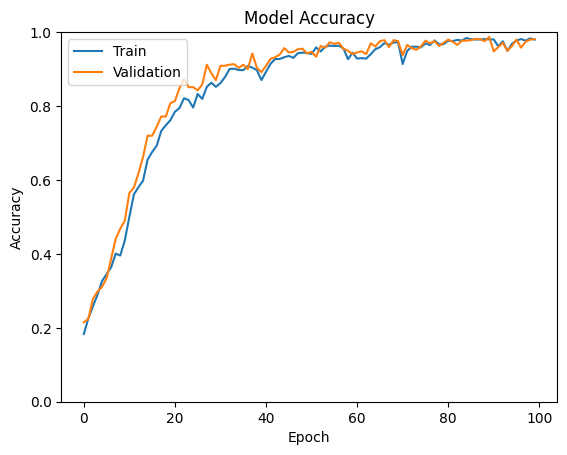

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

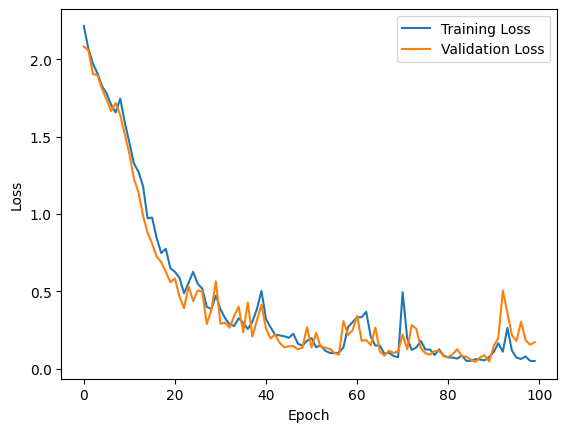

In [60]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
print(conf_mat)

report = classification_report(y_test_values, predictions)
print(report)


[[55  0  0  0  0  0  0  0  0  0]
 [ 0 66  0  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  1  0 73  2  0  1  0  0  0]
 [ 0  0  0  1 52  0  0  0  0  0]
 [ 0  0  0  0  0 70  0  0  0  0]
 [ 0  1  0  0  1  0 72  1  2  0]
 [ 0  0  0  0  0  0  0 83  0  0]
 [ 0  0  0  0  0  0  0  0 73  0]
 [ 0  0  0  0  0  3  0  0  0 66]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.97      1.00      0.99        66
           2       1.00      1.00      1.00        69
           3       0.99      0.95      0.97        77
           4       0.95      0.98      0.96        53
           5       0.96      1.00      0.98        70
           6       0.99      0.94      0.96        77
           7       0.99      1.00      0.99        83
           8       0.97      1.00      0.99        73
           9       1.00      0.96      0.98        69

    accuracy                           0.98       692
   macro avg       

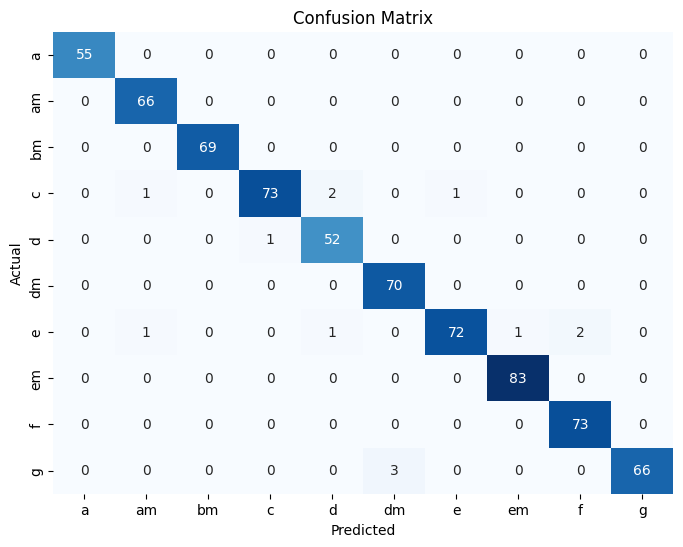

In [63]:
classes = list(CLASSES_MAP.keys())

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set the custom class labels
heatmap.set_xticklabels(classes)
heatmap.set_yticklabels(classes)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [64]:
model_json = model.to_json()
with open("./model/model1.json", "w") as json_file:
    json_file.write(model_json)

In [65]:
model.save_weights("./model/model1.h5")
print("Saved model to disk")

Saved model to disk


In [66]:
json_file = open('./model/model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model/model1.h5")
print("Loaded model from disk")

Loaded model from disk


In [67]:
loaded_model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

In [68]:
y, sr = librosa.load('./data/mainPrediction/audiofile.wav')
total_duration = librosa.get_duration(y=y, sr=sr)
iterate = math.floor(total_duration/2)
predVal = {}
for i in range(0, iterate):
    start_time = i*2
    start_index = int(start_time * sr)
    end_index = int(start_index + (sr*2))
    segment = y[start_index:end_index]
    ps = librosa.feature.melspectrogram(y=segment, sr=sr)
    ps = np.array(ps.reshape(1, 128, 87, 1))
    predicted = loaded_model.predict(ps)
    predicted = np.argmax(predicted, axis=1)
    predVal[int(end_index/sr)]=CLASSES[predicted[0]]

keys = list(predVal.keys())
values = list(predVal.values())
heatData = np.zeros((len(CLASSES),len(keys)))
k=0
for i, j in predVal.items():
    if k != len(keys):
        heatData[CLASSES.index(j)][k] = 1
        k = k+1

1/1 [==============================] - 0s 29ms/step


In [69]:
print(values)
heatData

['g', 'g', 'am', 'am', 'am', 'am', 'a', 'e', 'g', 'em', 'am', 'a', 'a', 'am', 'am', 'e']


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

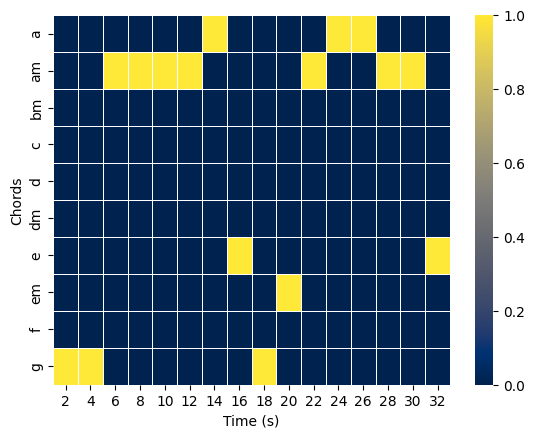

In [70]:
hm = sns.heatmap(heatData, cmap="cividis", yticklabels=CLASSES, xticklabels= keys, linewidths=0.5, linecolor='white') 
plt.xlabel("Time (s)")
plt.ylabel("Chords")
plt.savefig('result.png')

In [3]:
# !pip install tensorflow-gpu==2.15
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
